In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os 
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load Data
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    print("X FILE TIDAK DITEMUKAN!")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)

print(f"Data siap. Jumlah baris: {len(raw_data)}")
print("Melanjutkan ke Uji Coba Skenario A...")

# DEFINISI FUNGSI & ARSITEKTUR

def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1)) 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# EKSEKUSI UJI COBA SKENARIO A
scenario_windows = [30, 60, 90]


FIXED_EPOCH = 100      
FIXED_BATCH_SIZE = 30 

# PERUBAHAN 3: Definisi Early Stopping (Berhenti jika loss tidak turun selama 10 epoch)
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

results = []

print("\n" + "="*50)
print("MULAI UJI COBA SKENARIO A (Epoch 100 + Early Stopping)")
print("="*50)

for win_size in scenario_windows:
    print(f"\n[Proses] Training Window Size: {win_size}...")
    
    # A. Transformasi Data
    X, Y = create_sliding_window(raw_data, win_size)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # B. Split Data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]
    
    # C. Pelatihan Model
    model = build_model_lstm((X_train.shape[1], 1))
    
    # PERUBAHAN 4: Menambahkan callbacks saat training
    model.fit(X_train, y_train, 
              epochs=FIXED_EPOCH, 
              batch_size=FIXED_BATCH_SIZE, 
              callbacks=[early_stop],
              verbose=0)
    
    # D. Evaluasi
    predictions = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    
    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")
    results.append({'Window Size': win_size, 'MAPE (%)': mape})

# HASIL AKHIR
print("\n" + "="*50)
print("TABEL HASIL PERBANDINGAN")
print("="*50)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_window = int(best_result['Window Size'])

print("-" * 50)
print(f"KESIMPULAN TAHAP 1:")
print(f"Window Size Terbaik: {best_window}")
print(f"MAPE Terendah: {best_result['MAPE (%)']:.4f}%")
print("="*50)

✓ Data berhasil dimuat.
Data siap. Jumlah baris: 1043
Melanjutkan ke Uji Coba Skenario A...

MULAI UJI COBA SKENARIO A (Epoch 100 + Early Stopping)

[Proses] Training Window Size: 30...
7/7 [==============================] - 5s 53ms/step
   -> Selesai. Hasil MAPE: 60.3400%

[Proses] Training Window Size: 60...
7/7 [==============================] - 3s 87ms/step
   -> Selesai. Hasil MAPE: 52.9928%

[Proses] Training Window Size: 90...
6/6 [==============================] - 2s 103ms/step
   -> Selesai. Hasil MAPE: 66.2922%

TABEL HASIL PERBANDINGAN
   Window Size   MAPE (%)
0           30  60.339963
1           60  52.992785
2           90  66.292244
--------------------------------------------------
KESIMPULAN TAHAP 1:
Window Size Terbaik: 60
MAPE Terendah: 52.9928%


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os 
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load Data
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    print("X FILE TIDAK DITEMUKAN!")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)

print(f"Data siap. Jumlah baris: {len(raw_data)}")
print("Melanjutkan ke Uji Coba Skenario A (Low LR)...")

# DEFINISI FUNGSI & ARSITEKTUR

def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1)) 
    
    # 1. Learning Rate dikecilkan jadi 0.00001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='mean_squared_error')
    return model

# EKSEKUSI UJI COBA SKENARIO A
scenario_windows = [30, 60, 90]

FIXED_EPOCH = 100      
FIXED_BATCH_SIZE = 30 

# Early Stopping tetap dipakai
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

results = []

print("\n" + "="*50)
print("MULAI UJI COBA SKENARIO A (LR Kecil 0.00001)")
print("="*50)

for win_size in scenario_windows:
    print(f"\n[Proses] Training Window Size: {win_size}...")
    
    # A. Transformasi Data
    X, Y = create_sliding_window(raw_data, win_size)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # B. Split Data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]
    
    # C. Pelatihan Model
    model = build_model_lstm((X_train.shape[1], 1))
    
    model.fit(X_train, y_train, 
              epochs=FIXED_EPOCH, 
              batch_size=FIXED_BATCH_SIZE, 
              callbacks=[early_stop], 
              verbose=0)
    
    # D. Evaluasi
    predictions = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    
    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")
    results.append({'Window Size': win_size, 'MAPE (%)': mape})

# HASIL AKHIR
print("\n" + "="*50)
print("TABEL HASIL PERBANDINGAN")
print("="*50)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_window = int(best_result['Window Size'])

print("-" * 50)
print(f"KESIMPULAN TAHAP 1:")
print(f"Window Size Terbaik: {best_window}")
print(f"MAPE Terendah: {best_result['MAPE (%)']:.4f}%")
print("="*50)

✓ Data berhasil dimuat.
Data siap. Jumlah baris: 1043
Melanjutkan ke Uji Coba Skenario A (Low LR)...

MULAI UJI COBA SKENARIO A (LR Kecil 0.00001)

[Proses] Training Window Size: 30...
7/7 [==============================] - 2s 18ms/step
   -> Selesai. Hasil MAPE: 99.9421%

[Proses] Training Window Size: 60...
7/7 [==============================] - 10s 214ms/step
   -> Selesai. Hasil MAPE: 99.9477%

[Proses] Training Window Size: 90...
6/6 [==============================] - 3s 115ms/step
   -> Selesai. Hasil MAPE: 99.9417%

TABEL HASIL PERBANDINGAN
   Window Size   MAPE (%)
0           30  99.942100
1           60  99.947733
2           90  99.941671
--------------------------------------------------
KESIMPULAN TAHAP 1:
Window Size Terbaik: 90
MAPE Terendah: 99.9417%


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os 
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load Data
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    print("X FILE TIDAK DITEMUKAN!")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)

print(f"Data siap. Jumlah baris: {len(raw_data)}")
print("Melanjutkan ke Uji Coba Skenario A (4 Layer LSTM)...")

# DEFINISI FUNGSI & ARSITEKTUR

def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    model = Sequential()
    
    # 4 LAYER LSTM ---
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))
    
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))
    
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1)) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# EKSEKUSI UJI COBA SKENARIO A
scenario_windows = [30, 60, 90]

FIXED_EPOCH = 100      
FIXED_BATCH_SIZE = 30 

# Early Stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

results = []

print("\n" + "="*50)
print("MULAI UJI COBA SKENARIO A (4 LAYER LSTM)")
print("="*50)

for win_size in scenario_windows:
    print(f"\n[Proses] Training Window Size: {win_size}...")
    
    # A. Transformasi Data
    X, Y = create_sliding_window(raw_data, win_size)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # B. Split Data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]
    
    # C. Pelatihan Model
    model = build_model_lstm((X_train.shape[1], 1))
    
    # Callbacks
    model.fit(X_train, y_train, 
              epochs=FIXED_EPOCH, 
              batch_size=FIXED_BATCH_SIZE, 
              callbacks=[early_stop],
              verbose=0)
    
    # D. Evaluasi
    predictions = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    
    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")
    results.append({'Window Size': win_size, 'MAPE (%)': mape})

# HASIL AKHIR
print("\n" + "="*50)
print("TABEL HASIL PERBANDINGAN (4 LAYER)")
print("="*50)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_window = int(best_result['Window Size'])

print("-" * 50)
print(f"KESIMPULAN TAHAP 1:")
print(f"Window Size Terbaik: {best_window}")
print(f"MAPE Terendah: {best_result['MAPE (%)']:.4f}%")
print("="*50)

✓ Data berhasil dimuat.
Data siap. Jumlah baris: 1043
Melanjutkan ke Uji Coba Skenario A (4 Layer LSTM)...

MULAI UJI COBA SKENARIO A (4 LAYER LSTM)

[Proses] Training Window Size: 30...
7/7 [==============================] - 9s 217ms/step
   -> Selesai. Hasil MAPE: 72.4947%

[Proses] Training Window Size: 60...
7/7 [==============================] - 7s 93ms/step
   -> Selesai. Hasil MAPE: 53.1372%

[Proses] Training Window Size: 90...
6/6 [==============================] - 5s 179ms/step
   -> Selesai. Hasil MAPE: 66.5823%

TABEL HASIL PERBANDINGAN (4 LAYER)
   Window Size   MAPE (%)
0           30  72.494733
1           60  53.137243
2           90  66.582334
--------------------------------------------------
KESIMPULAN TAHAP 1:
Window Size Terbaik: 60
MAPE Terendah: 53.1372%


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os 
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load Data
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    print("X FILE TIDAK DITEMUKAN!")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)

print(f"Data siap. Jumlah baris: {len(raw_data)}")
print("Melanjutkan ke Uji Coba Skenario A (3 Layer LSTM)...")

# DEFINISI FUNGSI & ARSITEKTUR

def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    model = Sequential()
    
    #3 LAYER LSTM
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    
    # Layer Output
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1)) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# EKSEKUSI UJI COBA SKENARIO A
scenario_windows = [30, 60, 90]

FIXED_EPOCH = 100      
FIXED_BATCH_SIZE = 30 

# Early Stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

results = []

print("\n" + "="*50)
print("MULAI UJI COBA SKENARIO A (3 LAYER LSTM)")
print("="*50)

for win_size in scenario_windows:
    print(f"\n[Proses] Training Window Size: {win_size}...")
    
    # A. Transformasi Data
    X, Y = create_sliding_window(raw_data, win_size)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # B. Split Data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]
    
    # C. Pelatihan Model
    model = build_model_lstm((X_train.shape[1], 1))
    
    # Callbacks
    model.fit(X_train, y_train, 
              epochs=FIXED_EPOCH, 
              batch_size=FIXED_BATCH_SIZE, 
              callbacks=[early_stop],
              verbose=0)
    
    # D. Evaluasi
    predictions = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    
    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")
    results.append({'Window Size': win_size, 'MAPE (%)': mape})

# HASIL AKHIR
print("\n" + "="*50)
print("TABEL HASIL PERBANDINGAN (3 LAYER)")
print("="*50)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_window = int(best_result['Window Size'])

print("-" * 50)
print(f"KESIMPULAN TAHAP 1:")
print(f"Window Size Terbaik: {best_window}")
print(f"MAPE Terendah: {best_result['MAPE (%)']:.4f}%")
print("="*50)

✓ Data berhasil dimuat.
Data siap. Jumlah baris: 1043
Melanjutkan ke Uji Coba Skenario A (3 Layer LSTM)...

MULAI UJI COBA SKENARIO A (3 LAYER LSTM)

[Proses] Training Window Size: 30...
7/7 [==============================] - 4s 54ms/step
   -> Selesai. Hasil MAPE: 44.6637%

[Proses] Training Window Size: 60...
7/7 [==============================] - 5s 89ms/step
   -> Selesai. Hasil MAPE: 43.2242%

[Proses] Training Window Size: 90...
6/6 [==============================] - 3s 157ms/step
   -> Selesai. Hasil MAPE: 66.1889%

TABEL HASIL PERBANDINGAN (3 LAYER)
   Window Size   MAPE (%)
0           30  44.663686
1           60  43.224183
2           90  66.188884
--------------------------------------------------
KESIMPULAN TAHAP 1:
Window Size Terbaik: 60
MAPE Terendah: 43.2242%


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os 
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load Data
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    print("X FILE TIDAK DITEMUKAN!")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)

print(f"Data siap. Jumlah baris: {len(raw_data)}")
print("Melanjutkan ke Uji Coba Skenario B (Variasi Epoch)...")

# =============================================================================
# KONFIGURASI DARI TAHAP SEBELUMNYA (HASIL SKENARIO A)
# =============================================================================

FIXED_WINDOW_SIZE = 21   
FIXED_BATCH_SIZE = 30    


scenario_epochs = [16, 30, 50]

# Definisi Early Stopping
# patience  kecil agar kalau stuck dia berhenti
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# =============================================================================
# FUNGSI & MODEL
# =============================================================================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    model = Sequential()
    # Arsitektur 2 Layer 
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1)) 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# =============================================================================
# EKSEKUSI SKENARIO B
# =============================================================================

# Siapkan data dengan Window Pemenang
X, Y = create_sliding_window(raw_data, FIXED_WINDOW_SIZE)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split Data 80:20
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

results = []

print("\n" + "="*50)
print("MULAI UJI COBA SKENARIO B (Mencari Epoch Terbaik)")
print(f"Kondisi: Tanpa Normalisasi | Window Size: {FIXED_WINDOW_SIZE}")
print("="*50)

for epoch_target in scenario_epochs:
    print(f"\n[Proses] Training dengan Target Epoch: {epoch_target} ...")
    
    # Reset Model Baru
    model = build_model_lstm((X_train.shape[1], 1))
    
    # Training
    #  pasang early_stop dibatasi oleh 'epoch_target' (16, 30, atau 50)
    history = model.fit(X_train, y_train, 
                        epochs=epoch_target, 
                        batch_size=FIXED_BATCH_SIZE, 
                        callbacks=[early_stop],
                        verbose=0)
    
    # Cek dia berhenti di epoch berapa (Actual Epoch)
    actual_epoch = len(history.history['loss'])
    
    # Evaluasi
    predictions = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    
    print(f"   -> Selesai di Epoch {actual_epoch}/{epoch_target}. Hasil MAPE: {mape:.4f}%")
    results.append({
        'Target Epoch': epoch_target, 
        'Actual Epoch': actual_epoch,
        'MAPE (%)': mape
    })

# =============================================================================
# HASIL AKHIR
# =============================================================================
print("\n" + "="*50)
print("TABEL HASIL PERBANDINGAN SKENARIO B")
print("="*50)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_epoch_config = int(best_result['Target Epoch'])

print("-" * 50)
print(f"KESIMPULAN TAHAP 2:")
print(f"Epoch Terbaik adalah: {best_epoch_config}")
print(f"Dengan MAPE: {best_result['MAPE (%)']:.4f}%")
print("="*50)

✓ Data berhasil dimuat.
Data siap. Jumlah baris: 1043
Melanjutkan ke Uji Coba Skenario B (Variasi Epoch)...

MULAI UJI COBA SKENARIO B (Mencari Epoch Terbaik)
Kondisi: Tanpa Normalisasi | Window Size: 21

[Proses] Training dengan Target Epoch: 16 ...
7/7 [==============================] - 1s 18ms/step
   -> Selesai di Epoch 16/16. Hasil MAPE: 98.0341%

[Proses] Training dengan Target Epoch: 30 ...
7/7 [==============================] - 1s 23ms/step
   -> Selesai di Epoch 30/30. Hasil MAPE: 94.4191%

[Proses] Training dengan Target Epoch: 50 ...
7/7 [==============================] - 1s 22ms/step
   -> Selesai di Epoch 50/50. Hasil MAPE: 81.4050%

TABEL HASIL PERBANDINGAN SKENARIO B
   Target Epoch  Actual Epoch   MAPE (%)
0            16            16  98.034078
1            30            30  94.419050
2            50            50  81.404972
--------------------------------------------------
KESIMPULAN TAHAP 2:
Epoch Terbaik adalah: 50
Dengan MAPE: 81.4050%


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# 2. Load Data
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    print("X FILE TIDAK DITEMUKAN!")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)

# =============================================================================
# KONFIGURASI DARI TAHAP SEBELUMNYA
# =============================================================================
FIXED_WINDOW_SIZE = 21   
FIXED_EPOCH = 50         

# Variasi Batch Size
scenario_batch_sizes = [16, 30, 64]

# Early Stopping (Patience agak longgar biar adil)
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# =============================================================================
# FUNGSI & MODEL
# =============================================================================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    # Reset seed di dalam fungsi
    tf.random.set_seed(42)
    model = Sequential()
    # Arsitektur 2 Layer (Balik ke Standard biar ringan)
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1)) 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# =============================================================================
# EKSEKUSI SKENARIO C (VARIASI BATCH SIZE)
# =============================================================================

# Siapkan data (Window 23)
X, Y = create_sliding_window(raw_data, FIXED_WINDOW_SIZE)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split Data 80:20
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

results = []

print("\n" + "="*50)
print("MULAI UJI COBA SKENARIO C (Mencari Batch Size Terbaik)")
print(f"Konfigurasi: Window {FIXED_WINDOW_SIZE} | Epoch {FIXED_EPOCH} | Tanpa Normalisasi")
print("="*50)

for batch_count in scenario_batch_sizes:
    print(f"\n[Proses] Training dengan Batch Size: {batch_count} ...")
    
    # Reset Seed sebelum training
    reset_seeds()
    
    model = build_model_lstm((X_train.shape[1], 1))
    
    # Training
    model.fit(X_train, y_train, 
              epochs=FIXED_EPOCH,          
              batch_size=batch_count,      # Variabel Uji
              callbacks=[early_stop],
              verbose=0,
              shuffle=False)
    
    # Evaluasi
    predictions = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    
    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")
    results.append({'Batch Size': batch_count, 'MAPE (%)': mape})

# =============================================================================
# HASIL AKHIR FASE 1
# =============================================================================
print("\n" + "="*50)
print("TABEL HASIL PERBANDINGAN SKENARIO C")
print("="*50)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_batch = int(best_result['Batch Size'])

print("-" * 50)
print(f"KESIMPULAN AKHIR FASE 1 (TANPA NORMALISASI):")
print(f"Konfigurasi Terbaik Ditemukan:")
print(f"1. Window Size : {FIXED_WINDOW_SIZE}")
print(f"2. Epoch       : {FIXED_EPOCH}")
print(f"3. Batch Size  : {best_batch}")
print(f"MAPE Terendah  : {best_result['MAPE (%)']:.4f}%")
print("="*50)
print("CATATAN: Jika MAPE masih tinggi (>20%), ini adalah bukti kuat")
print("bahwa Fase 2 (Normalisasi) mutlak diperlukan dalam pembahasan Bab 4.")

✓ Data berhasil dimuat.

MULAI UJI COBA SKENARIO C (Mencari Batch Size Terbaik)
Konfigurasi: Window 21 | Epoch 50 | Tanpa Normalisasi

[Proses] Training dengan Batch Size: 16 ...
7/7 [==============================] - 4s 45ms/step
   -> Selesai. Hasil MAPE: 51.7250%

[Proses] Training dengan Batch Size: 30 ...
7/7 [==============================] - 6s 59ms/step
   -> Selesai. Hasil MAPE: 82.1934%

[Proses] Training dengan Batch Size: 64 ...
7/7 [==============================] - 4s 55ms/step
   -> Selesai. Hasil MAPE: 95.4721%

TABEL HASIL PERBANDINGAN SKENARIO C
   Batch Size   MAPE (%)
0          16  51.724976
1          30  82.193422
2          64  95.472062
--------------------------------------------------
KESIMPULAN AKHIR FASE 1 (TANPA NORMALISASI):
Konfigurasi Terbaik Ditemukan:
1. Window Size : 21
2. Epoch       : 50
3. Batch Size  : 16
MAPE Terendah  : 51.7250%
CATATAN: Jika MAPE masih tinggi (>20%), ini adalah bukti kuat
bahwa Fase 2 (Normalisasi) mutlak diperlukan dalam pemb

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load Data
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    print("X FILE TIDAK DITEMUKAN!")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)

# FUNGSI & MODEL
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1)) 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model
#1 minggu (7), 2 minggu (14), 3 minggu (21)
scenario_windows = [7, 14, 21]

FIXED_EPOCH = 100      
FIXED_BATCH_SIZE = 30 

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

results = []

print("\n" + "="*50)
print("MULAI UJI COBA TAMBAHAN (WINDOW SIZE KECIL)")
print("Hipotesis: Window kecil lebih baik untuk data mentah")
print("="*50)

for win_size in scenario_windows:
    print(f"\n[Proses] Training Window Size: {win_size}...")
    
    # A. Transformasi Data
    X, Y = create_sliding_window(raw_data, win_size)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # B. Split Data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]
    
    # C. Pelatihan Model
    model = build_model_lstm((X_train.shape[1], 1))
    
    model.fit(X_train, y_train, 
              epochs=FIXED_EPOCH, 
              batch_size=FIXED_BATCH_SIZE, 
              callbacks=[early_stop], 
              verbose=0)
    
    # D. Evaluasi
    predictions = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    
    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")
    results.append({'Window Size': win_size, 'MAPE (%)': mape})

# HASIL AKHIR
print("\n" + "="*50)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_window = int(best_result['Window Size'])

print("-" * 50)
print(f"KESIMPULAN UJI TAMBAHAN:")
print(f"Window Size Terbaik: {best_window}")
print(f"MAPE Terendah: {best_result['MAPE (%)']:.4f}%")
print("="*50)

✓ Data berhasil dimuat.

MULAI UJI COBA TAMBAHAN (WINDOW SIZE KECIL)
Hipotesis: Window kecil lebih baik untuk data mentah

[Proses] Training Window Size: 7...
7/7 [==============================] - 1s 8ms/step
   -> Selesai. Hasil MAPE: 70.9778%

[Proses] Training Window Size: 14...
7/7 [==============================] - 2s 13ms/step
   -> Selesai. Hasil MAPE: 70.8817%

[Proses] Training Window Size: 21...
7/7 [==============================] - 1s 18ms/step
   -> Selesai. Hasil MAPE: 37.3623%

   Window Size   MAPE (%)
0            7  70.977783
1           14  70.881742
2           21  37.362292
--------------------------------------------------
KESIMPULAN UJI TAMBAHAN:
Window Size Terbaik: 21
MAPE Terendah: 37.3623%


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# 2. Load Data
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
else:
    print("X File tidak ditemukan.")

# Data Mentah (Tanpa Normalisasi)
raw_data = df['Harga (Rp)'].values.reshape(-1, 1)

# FUNGSI & MODEL
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    tf.random.set_seed(42) # Kunci bobot awal
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1)) 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# =============================================================================
# TEKNIK GRID SEARCH (SCANNING OTOMATIS)
# ============================================================================
# range(15, 26) artinya 15, 16, ..., 25
scan_range = range(15, 26) 

FIXED_EPOCH = 100
FIXED_BATCH_SIZE = 30
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

results = []

print("\n" + "="*50)
print("MULAI SCANNING OTOMATIS (WINDOW 15 s.d 25)")
print("="*50)

for win_size in scan_range:
    reset_seeds()
    
    # Proses Data
    X, Y = create_sliding_window(raw_data, win_size)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # Split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]
    
    # Training
    model = build_model_lstm((X_train.shape[1], 1))
    model.fit(X_train, y_train, 
              epochs=FIXED_EPOCH, 
              batch_size=FIXED_BATCH_SIZE, 
              callbacks=[early_stop], 
              verbose=0,
              shuffle=False)
    
    # Evaluasi
    predictions = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    
    print(f"Window {win_size} -> MAPE: {mape:.4f}%")
    results.append({'Window Size': win_size, 'MAPE (%)': mape})

# HASIL AKHIR
print("\n" + "="*50)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MAPE (%)', ascending=True)
print(results_df)

best_result = results_df.iloc[0]
print("-" * 50)
print(f"JUARA SCANNING:")
print(f"Window Size Terbaik: {int(best_result['Window Size'])}")
print(f"MAPE Terendah: {best_result['MAPE (%)']:.4f}%")
print("="*50)


MULAI SCANNING OTOMATIS (WINDOW 15 s.d 25)
7/7 [==============================] - 1s 17ms/step
Window 15 -> MAPE: 43.2970%
7/7 [==============================] - 1s 12ms/step
Window 16 -> MAPE: 44.5322%
7/7 [==============================] - 1s 14ms/step
Window 17 -> MAPE: 46.3834%
7/7 [==============================] - 1s 14ms/step
Window 18 -> MAPE: 46.3305%
7/7 [==============================] - 1s 19ms/step
Window 19 -> MAPE: 40.3218%
7/7 [==============================] - 1s 37ms/step
Window 20 -> MAPE: 43.1371%
7/7 [==============================] - 2s 31ms/step
Window 21 -> MAPE: 46.2242%
7/7 [==============================] - 2s 32ms/step
Window 22 -> MAPE: 40.3623%
7/7 [==============================] - 2s 38ms/step
Window 23 -> MAPE: 40.1088%
7/7 [==============================] - 1s 42ms/step
Window 24 -> MAPE: 44.5588%
7/7 [==============================] - 1s 20ms/step
Window 25 -> MAPE: 40.2316%

    Window Size   MAPE (%)
8            23  40.108824
10           25  40.2

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random

from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ===========================================================
# 1. FIXED RANDOM SEED
# ===========================================================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# ===========================================================
# 2. LOAD DATA
# ===========================================================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"

if not os.path.exists(path_file_input):
    raise FileNotFoundError("FILE TIDAK DITEMUKAN!")

df = pd.read_excel(path_file_input)

# Pastikan kolom harga ada
if "Harga (Rp)" not in df.columns:
    raise ValueError("Kolom 'Harga (Rp)' tidak ditemukan!")

raw_data = df["Harga (Rp)"].values.astype(float).reshape(-1, 1)

print(f"✓ Data berhasil dimuat ({len(raw_data)} baris)")

# ===========================================================
# 3. FUNGSI SLIDING WINDOW
# ===========================================================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

# ===========================================================
# 4. MODEL LSTM (6 LAYER SESUAI PERMINTAAN)
# ===========================================================
def build_model_lstm(input_shape):
    reset_seeds() 

    model = Sequential()

    # Layer 1
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))

    # Layer 2
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 3
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 4
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 5
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 6 (final)
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))

    # Dense output
    model.add(Dense(25, activation="relu"))
    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mean_squared_error"
    )

    return model

# ===========================================================
# 5. TRAINING MULTI WINDOW
# ===========================================================
scenario_windows = [30, 60, 90]

EPOCHS = 500
BATCH_SIZE = 30

early_stop = EarlyStopping(
    monitor="loss",
    patience=10,
    restore_best_weights=True
)

results = []

print("\n============================================================")
print("MULAI TRAINING (NO NORMALIZATION | 6-LAYER LSTM | SEED 42)")
print("============================================================\n")

for win_size in scenario_windows:
    print(f"[Training] Window size = {win_size}")

    reset_seeds()

    # Sliding window
    X, Y = create_sliding_window(raw_data, win_size)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split 80:20
    train_size = int(len(X) * 0.8)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]

    # Buat model
    model = build_model_lstm((X_train.shape[1], 1))

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False  # penting untuk time-series
    )

    # Info epoch
    total_epoch = len(history.history["loss"])
    best_idx = np.argmin(history.history["loss"])
    best_loss = history.history["loss"][best_idx]

    print(f"   -> Selesai epoch: {total_epoch}")
    print(f"   -> Best epoch : {best_idx+1} (loss={best_loss:.2f})")

    # Prediction
    predictions = model.predict(X_test)

    # Hitung MAPE
    mape = mean_absolute_percentage_error(y_test, predictions) * 100

    print(f"   -> MAPE: {mape:.4f}%\n")

    # Simpan hasil
    results.append({
        "Window Size": win_size,
        "Stop Epoch": total_epoch,
        "Best Epoch": best_idx + 1,
        "MAPE (%)": mape
    })

# ===========================================================
# 6. HASIL TABEL
# ===========================================================
results_df = pd.DataFrame(results)
print("\n============================================================")
print("TABEL HASIL PERCOBAAN")
print("============================================================")
print(results_df)

best_row = results_df.loc[results_df["MAPE (%)"].idxmin()]
print("\n------------------------------------------------------------")
print(f"WINDOW TERBAIK : {int(best_row['Window Size'])}")
print(f"MAPE TERENDAH  : {best_row['MAPE (%)']:.4f}%")
print("============================================================\n")


✓ Data berhasil dimuat (1043 baris)

MULAI TRAINING (NO NORMALIZATION | 6-LAYER LSTM | SEED 42)

[Training] Window size = 30
   -> Selesai epoch: 209
   -> Best epoch : 199 (loss=59859524.00)
7/7 [==============================] - 6s 51ms/step
   -> MAPE: 23.4705%

[Training] Window size = 60
   -> Selesai epoch: 233
   -> Best epoch : 223 (loss=61444816.00)
7/7 [==============================] - 6s 129ms/step
   -> MAPE: 24.2146%

[Training] Window size = 90
   -> Selesai epoch: 217
   -> Best epoch : 207 (loss=63797712.00)
6/6 [==============================] - 6s 198ms/step
   -> MAPE: 24.2607%


TABEL HASIL PERCOBAAN
   Window Size  Stop Epoch  Best Epoch   MAPE (%)
0           30         209         199  23.470468
1           60         233         223  24.214639
2           90         217         207  24.260726

------------------------------------------------------------
WINDOW TERBAIK : 30
MAPE TERENDAH  : 23.4705%



✓ Data berhasil dimuat: 1043 baris


TRAINING TANPA NORMALISASI

[Training] Window Size = 7
   -> Selesai epoch: 223
   -> Best epoch : 212 (loss=59150884.00)
7/7 [==============================] - 5s 19ms/step
   -> MAPE: 23.1050%
   -> File Excel tersimpan: E:\SKRIPSI 2025\TIDAK NORMALISASI DATA\Hasil_Prediksi_Window_7.xlsx


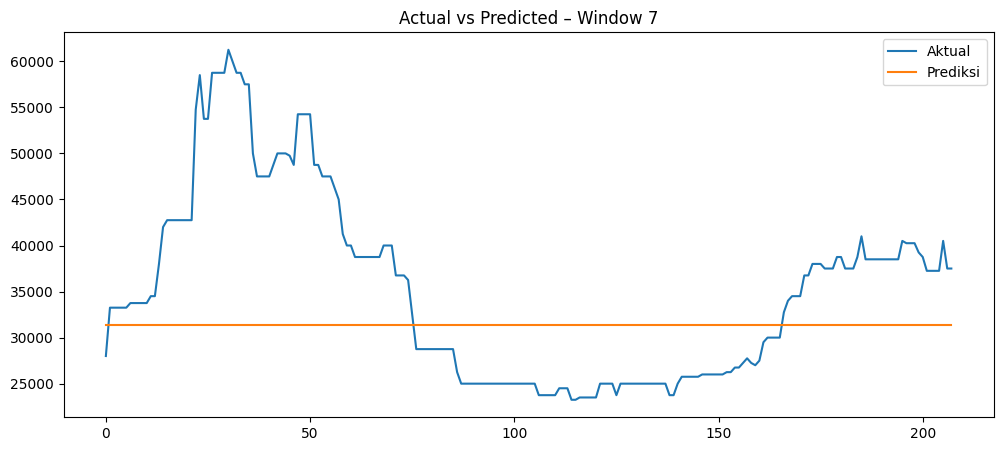

   -> Grafik ditampilkan

[Training] Window Size = 14
   -> Selesai epoch: 214
   -> Best epoch : 203 (loss=59562504.00)
7/7 [==============================] - 5s 30ms/step
   -> MAPE: 23.1751%
   -> File Excel tersimpan: E:\SKRIPSI 2025\TIDAK NORMALISASI DATA\Hasil_Prediksi_Window_14.xlsx


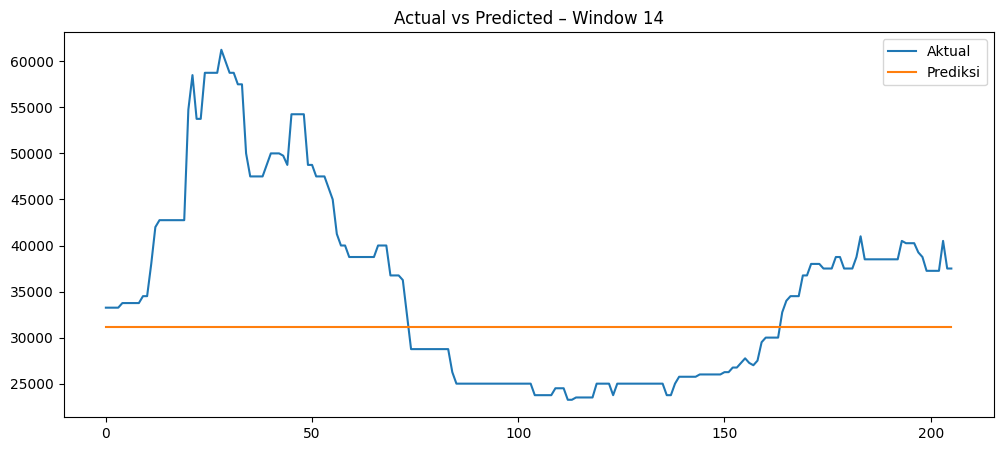

   -> Grafik ditampilkan

[Training] Window Size = 21
   -> Selesai epoch: 222
   -> Best epoch : 211 (loss=59386088.00)
7/7 [==============================] - 5s 48ms/step
   -> MAPE: 23.3734%
   -> File Excel tersimpan: E:\SKRIPSI 2025\TIDAK NORMALISASI DATA\Hasil_Prediksi_Window_21.xlsx


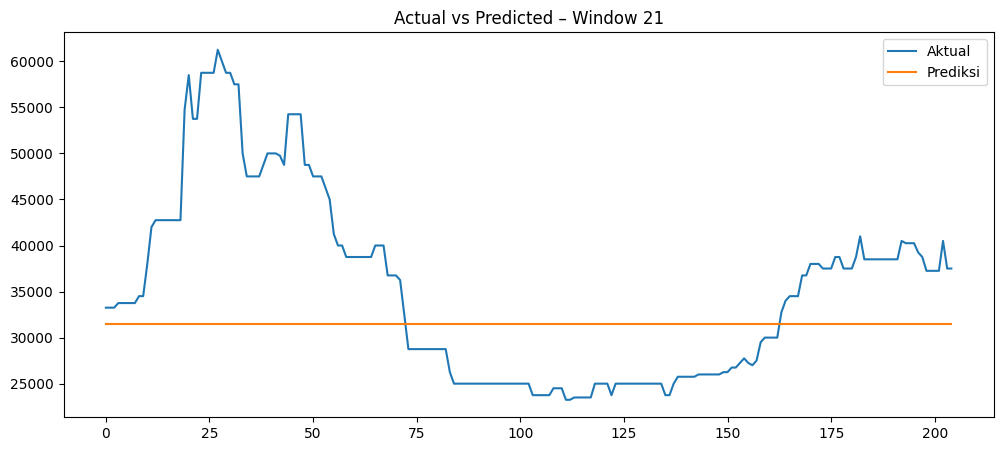

   -> Grafik ditampilkan


TABEL HASIL TRAINING
   Window Size       MAPE
0            7  23.105028
1           14  23.175109
2           21  23.373447

>>> WINDOW TERBAIK: 7.0
>>> MAPE TERRENDAH: 23.105027830242378 %


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random as python_random

from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# ===========================================================
# 0. FIXED RANDOM SEED
# ===========================================================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()


# ===========================================================
# 1. LOAD DATA
# ===========================================================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\TIDAK NORMALISASI DATA"

os.makedirs(path_output_folder, exist_ok=True)

df = pd.read_excel(path_file_input)

if "Harga (Rp)" not in df.columns:
    raise ValueError("Kolom 'Harga (Rp)' tidak ditemukan!")

raw_data = df["Harga (Rp)"].values.astype(float).reshape(-1, 1)

print(f"✓ Data berhasil dimuat: {len(raw_data)} baris\n")


# ===========================================================
# 2. SLIDING WINDOW
# ===========================================================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)


# ===========================================================
# 3. MODEL LSTM (6 LAYER SESUAI PERMINTAAN)
# ===========================================================
def build_model_lstm(input_shape):
    reset_seeds()

    model = Sequential()

    # Layer 1
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))

    # Layer 2
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 3
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 4
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 5
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 6 (final)
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))

    # Dense output
    model.add(Dense(25, activation="relu"))
    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mean_squared_error"
    )
    return model


# ===========================================================
# 4. TRAINING 3 WINDOW SCENARIOS
# ===========================================================
scenario_windows = [7, 14, 21]
results = []

EPOCHS = 500
BATCH_SIZE = 30

early_stop = EarlyStopping(
    monitor="loss",
    patience=10,
    restore_best_weights=True
)

print("\n==============================================")
print("TRAINING TANPA NORMALISASI")
print("==============================================\n")

for win_size in scenario_windows:

    print(f"[Training] Window Size = {win_size}")

    # Siapkan data sliding window
    X, Y = create_sliding_window(raw_data, win_size)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    train_size = int(len(X) * 0.8)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]

    model = build_model_lstm((win_size, 1))

    # Training
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=False,
        callbacks=[early_stop],
        verbose=0
    )

    # ======================================================
    # PRINT EPOCH
    # ======================================================
    total_epoch = len(history.history["loss"])
    best_epoch = np.argmin(history.history["loss"])
    best_loss = history.history["loss"][best_epoch]

    print(f"   -> Selesai epoch: {total_epoch}")
    print(f"   -> Best epoch : {best_epoch} (loss={best_loss:.2f})")

    # Prediksi
    predictions = model.predict(X_test)

    # MAPE
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    print(f"   -> MAPE: {mape:.4f}%")

    # ======================================================
    # SIMPAN FILE EXCEL
    # ======================================================
    df_save = pd.DataFrame({
        "Aktual": y_test.flatten(),
        "Prediksi": predictions.flatten()
    })

    file_out = os.path.join(path_output_folder,
                            f"Hasil_Prediksi_Window_{win_size}.xlsx")

    df_save.to_excel(file_out, index=False)
    print(f"   -> File Excel tersimpan: {file_out}")

    # ======================================================
    # TAMPILKAN GRAFIK (TIDAK DISIMPAN)
    # ======================================================
    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label="Aktual")
    plt.plot(predictions, label="Prediksi")
    plt.title(f"Actual vs Predicted – Window {win_size}")
    plt.legend()
    plt.show()
    print(f"   -> Grafik ditampilkan\n")

    # Simpan ke hasil
    results.append({
        "Window Size": win_size,
        "MAPE": mape
    })


# ===========================================================
# 7. TABEL HASIL
# ===========================================================
results_df = pd.DataFrame(results)
print("\n==============================================")
print("TABEL HASIL TRAINING")
print("==============================================")
print(results_df)

best = results_df.loc[results_df["MAPE"].idxmin()]
print("\n>>> WINDOW TERBAIK:", best["Window Size"])
print(">>> MAPE TERRENDAH:", best["MAPE"], "%")


✓ Data berhasil dimuat: 1043 baris


TRAINING TANPA NORMALISASI

[Training] Window Size = 30
   -> Selesai epoch: 209
   -> Best epoch : 198 (loss=59859524.00)
7/7 [==============================] - 6s 50ms/step
   -> MAPE: 23.4705%
   -> File Excel tersimpan: E:\SKRIPSI 2025\TIDAK NORMALISASI DATA\Hasil_Prediksi_Window_30.xlsx


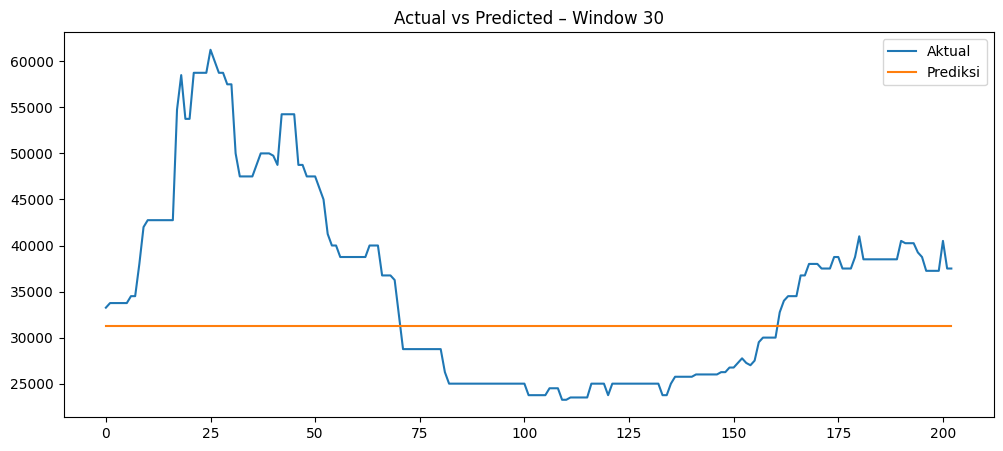

   -> Grafik ditampilkan

[Training] Window Size = 60
   -> Selesai epoch: 233
   -> Best epoch : 222 (loss=61444816.00)
7/7 [==============================] - 17s 272ms/step
   -> MAPE: 24.2146%
   -> File Excel tersimpan: E:\SKRIPSI 2025\TIDAK NORMALISASI DATA\Hasil_Prediksi_Window_60.xlsx


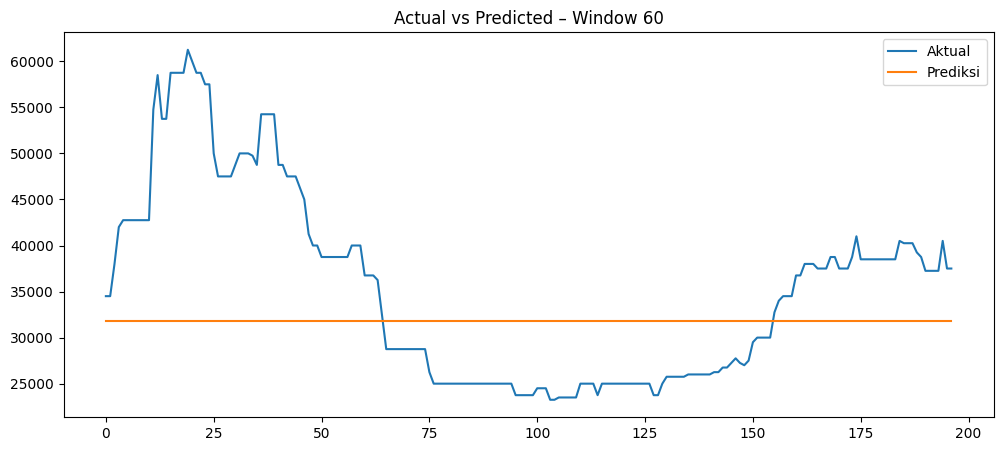

   -> Grafik ditampilkan

[Training] Window Size = 90
   -> Selesai epoch: 217
   -> Best epoch : 206 (loss=63797712.00)
6/6 [==============================] - 6s 201ms/step
   -> MAPE: 24.2607%
   -> File Excel tersimpan: E:\SKRIPSI 2025\TIDAK NORMALISASI DATA\Hasil_Prediksi_Window_90.xlsx


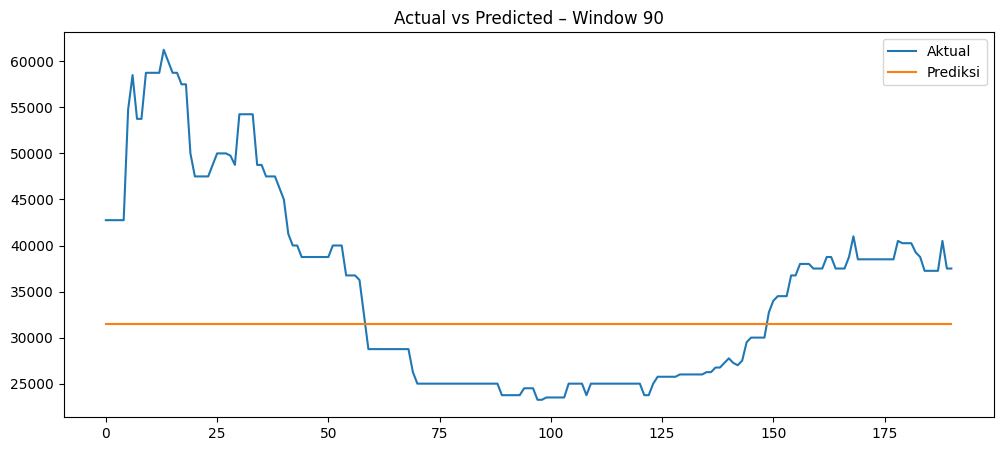

   -> Grafik ditampilkan


TABEL HASIL TRAINING
   Window Size       MAPE
0           30  23.470468
1           60  24.214639
2           90  24.260726

>>> WINDOW TERBAIK: 30.0
>>> MAPE TERRENDAH: 23.470468302138563 %


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random as python_random

from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# ===========================================================
# 0. FIXED RANDOM SEED
# ===========================================================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()


# ===========================================================
# 1. LOAD DATA
# ===========================================================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\TIDAK NORMALISASI DATA"

os.makedirs(path_output_folder, exist_ok=True)

df = pd.read_excel(path_file_input)

if "Harga (Rp)" not in df.columns:
    raise ValueError("Kolom 'Harga (Rp)' tidak ditemukan!")

raw_data = df["Harga (Rp)"].values.astype(float).reshape(-1, 1)

print(f"✓ Data berhasil dimuat: {len(raw_data)} baris\n")


# ===========================================================
# 2. SLIDING WINDOW
# ===========================================================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)


# ===========================================================
# 3. MODEL LSTM (6 LAYER SESUAI PERMINTAAN)
# ===========================================================
def build_model_lstm(input_shape):
    reset_seeds()

    model = Sequential()

    # Layer 1
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))

    # Layer 2
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 3
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 4
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 5
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.02))

    # Layer 6 (final)
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))

    # Dense output
    model.add(Dense(25, activation="relu"))
    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mean_squared_error"
    )
    return model


# ===========================================================
# 4. TRAINING 3 WINDOW SCENARIOS
# ===========================================================
scenario_windows = [30, 60, 90]
results = []

EPOCHS = 500
BATCH_SIZE = 30

early_stop = EarlyStopping(
    monitor="loss",
    patience=10,
    restore_best_weights=True
)

print("\n==============================================")
print("TRAINING TANPA NORMALISASI")
print("==============================================\n")

for win_size in scenario_windows:

    print(f"[Training] Window Size = {win_size}")

    # Siapkan data sliding window
    X, Y = create_sliding_window(raw_data, win_size)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    train_size = int(len(X) * 0.8)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]

    model = build_model_lstm((win_size, 1))

    # Training
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=False,
        callbacks=[early_stop],
        verbose=0
    )

    # ======================================================
    # PRINT EPOCH
    # ======================================================
    total_epoch = len(history.history["loss"])
    best_epoch = np.argmin(history.history["loss"])
    best_loss = history.history["loss"][best_epoch]

    print(f"   -> Selesai epoch: {total_epoch}")
    print(f"   -> Best epoch : {best_epoch} (loss={best_loss:.2f})")

    # Prediksi
    predictions = model.predict(X_test)

    # MAPE
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    print(f"   -> MAPE: {mape:.4f}%")

    # ======================================================
    # SIMPAN FILE EXCEL
    # ======================================================
    df_save = pd.DataFrame({
        "Aktual": y_test.flatten(),
        "Prediksi": predictions.flatten()
    })

    file_out = os.path.join(path_output_folder,
                            f"Hasil_Prediksi_Window_{win_size}.xlsx")

    df_save.to_excel(file_out, index=False)
    print(f"   -> File Excel tersimpan: {file_out}")

    # ======================================================
    # TAMPILKAN GRAFIK (TIDAK DISIMPAN)
    # ======================================================
    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label="Aktual")
    plt.plot(predictions, label="Prediksi")
    plt.title(f"Actual vs Predicted – Window {win_size}")
    plt.legend()
    plt.show()
    print(f"   -> Grafik ditampilkan\n")

    # Simpan ke hasil
    results.append({
        "Window Size": win_size,
        "MAPE": mape
    })


# ===========================================================
# 7. TABEL HASIL
# ===========================================================
results_df = pd.DataFrame(results)
print("\n==============================================")
print("TABEL HASIL TRAINING")
print("==============================================")
print(results_df)

best = results_df.loc[results_df["MAPE"].idxmin()]
print("\n>>> WINDOW TERBAIK:", best["Window Size"])
print(">>> MAPE TERRENDAH:", best["MAPE"], "%")


✓ Data berhasil dimuat dan dibersihkan: 1043 baris

TRAINING NON-NORMALISASI – LSTM TIDAK FLAT

[Training] Window Size = 7
   -> Selesai epoch: 300
   -> Best epoch : 299 (loss=1029364992.00)
7/7 [==============================] - 2s 13ms/step
   -> MAPE: 98.4384%
   -> File Excel tersimpan: E:\SKRIPSI 2025\TIDAK NORMALISASI DATA\Hasil_Prediksi_Window_7.xlsx


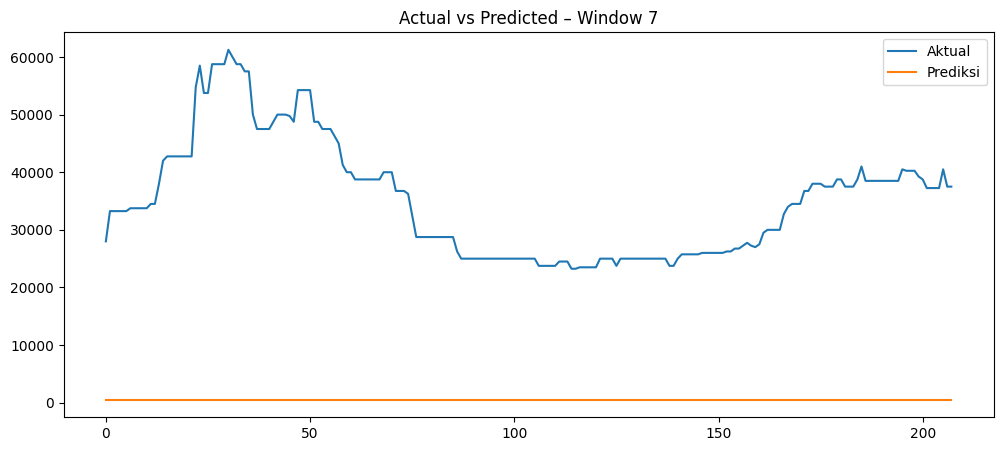

   -> Grafik ditampilkan

[Training] Window Size = 14
   -> Selesai epoch: 300
   -> Best epoch : 299 (loss=1031603840.00)
7/7 [==============================] - 2s 16ms/step
   -> MAPE: 98.4368%
   -> File Excel tersimpan: E:\SKRIPSI 2025\TIDAK NORMALISASI DATA\Hasil_Prediksi_Window_14.xlsx


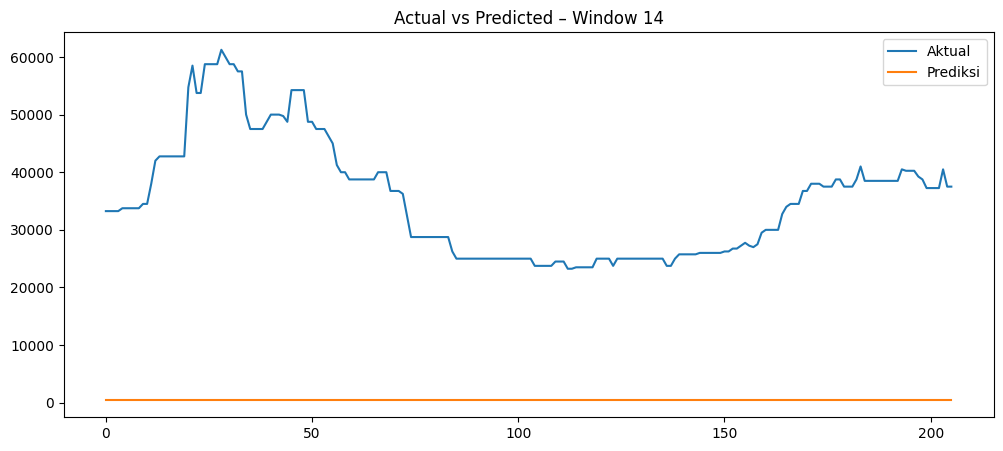

   -> Grafik ditampilkan

[Training] Window Size = 21
   -> Selesai epoch: 300
   -> Best epoch : 299 (loss=1034996480.00)
7/7 [==============================] - 7s 46ms/step
   -> MAPE: 98.4394%
   -> File Excel tersimpan: E:\SKRIPSI 2025\TIDAK NORMALISASI DATA\Hasil_Prediksi_Window_21.xlsx


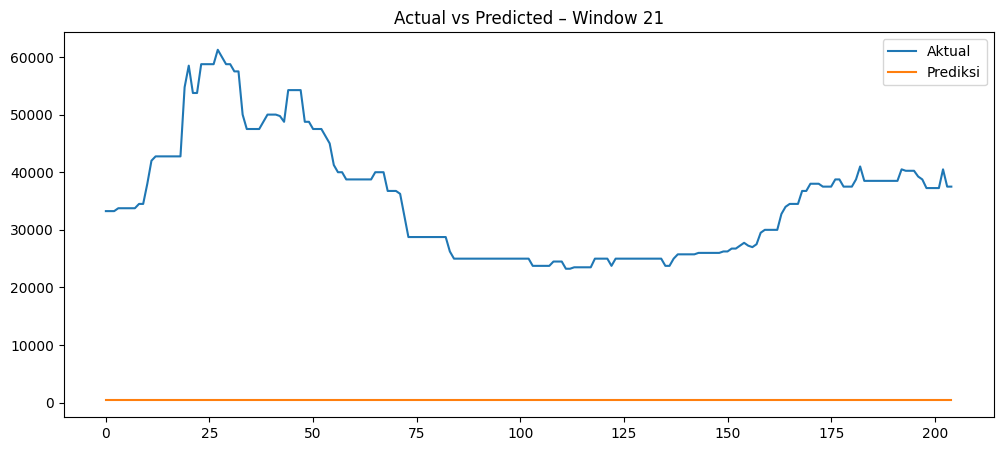

   -> Grafik ditampilkan

TABEL HASIL TRAINING
   Window Size       MAPE
0            7  98.438405
1           14  98.436766
2           21  98.439411

>>> WINDOW TERBAIK: 14.0
>>> MAPE TERENDAH : 98.43676552269494 %


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random as python_random

from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# ===========================================================
# 0. FIXED RANDOM SEED
# ===========================================================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()


# ===========================================================
# 1. LOAD DATA (NON-NORMALISASI + PEMBERSIHAN ANTI ERROR)
# ===========================================================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\TIDAK NORMALISASI DATA"

os.makedirs(path_output_folder, exist_ok=True)

df = pd.read_excel(path_file_input)

if "Harga (Rp)" not in df.columns:
    raise ValueError("Kolom 'Harga (Rp)' tidak ditemukan!")

# -------------------------------
# PEMBERSIHAN DATA (ANTI ERROR)
# -------------------------------
df["Harga (Rp)"] = (
    df["Harga (Rp)"]
    .astype(str)
    .str.replace(r"[^0-9]", "", regex=True)  # hapus titik, koma, Rp, spasi
)

df["Harga (Rp)"] = pd.to_numeric(df["Harga (Rp)"], errors="coerce")
df = df.dropna(subset=["Harga (Rp)"])

raw_data = df["Harga (Rp)"].values.astype(float).reshape(-1, 1)

print(f"✓ Data berhasil dimuat dan dibersihkan: {len(raw_data)} baris\n")


# ===========================================================
# 2. SLIDING WINDOW (gaya kamu)
# ===========================================================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)


# ===========================================================
# 3. MODEL LSTM (3 LAYER, NON-FLAT)
# ===========================================================
def build_model_lstm(input_shape):
    reset_seeds()

    model = Sequential()

    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.05))

    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.05))

    model.add(LSTM(32, return_sequences=False))

    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mean_squared_error")
    return model


# ===========================================================
scenario_windows = [30, 60, 90]
results = []

EPOCHS = 300
BATCH_SIZE = 16

early_stop = EarlyStopping(
    monitor="loss",
    patience=10,
    restore_best_weights=True
)

print("==============================================")
print("TRAINING NON-NORMALISASI – LSTM TIDAK FLAT")
print("==============================================\n")

for win_size in scenario_windows:

    print(f"[Training] Window Size = {win_size}")

    # dataset
    X, Y = create_sliding_window(raw_data, win_size)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    train_size = int(len(X) * 0.8)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = Y[:train_size], Y[train_size:]

    model = build_model_lstm((win_size, 1))

    # TRAINING
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=False,
        callbacks=[early_stop],
        verbose=0
    )

    # --------------------------------------------
    # CETAK BEST EPOCH
    # --------------------------------------------
    total_epoch = len(history.history["loss"])
    best_epoch = int(np.argmin(history.history["loss"]))
    best_loss = history.history["loss"][best_epoch]

    print(f"   -> Selesai epoch: {total_epoch}")
    print(f"   -> Best epoch : {best_epoch} (loss={best_loss:.2f})")

    # --------------------------------------------
    # PREDIKSI
    # --------------------------------------------
    predictions = model.predict(X_test)

    # MAPE
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    print(f"   -> MAPE: {mape:.4f}%")

    # --------------------------------------------
    # SIMPAN EXCEL HASIL
    # --------------------------------------------
    df_save = pd.DataFrame({
        "Aktual": y_test.flatten(),
        "Prediksi": predictions.flatten()
    })

    file_out = os.path.join(path_output_folder, f"Hasil_Prediksi_Window_{win_size}.xlsx")
    df_save.to_excel(file_out, index=False)
    print(f"   -> File Excel tersimpan: {file_out}")

    # --------------------------------------------
    # TAMPILKAN GRAFIK
    # --------------------------------------------
    plt.figure(figsize=(12, 5))
    plt.plot(y_test, label="Aktual")
    plt.plot(predictions, label="Prediksi")
    plt.title(f"Actual vs Predicted – Window {win_size}")
    plt.legend()
    plt.show()
    print(f"   -> Grafik ditampilkan\n")

    # Simpan ke tabel hasil
    results.append({"Window Size": win_size, "MAPE": mape})


# ===========================================================
# 5. TABEL HASIL
# ===========================================================
results_df = pd.DataFrame(results)
print("==============================================")
print("TABEL HASIL TRAINING")
print("==============================================")
print(results_df)

best = results_df.loc[results_df["MAPE"].idxmin()]
print("\n>>> WINDOW TERBAIK:", best["Window Size"])
print(">>> MAPE TERENDAH :", best["MAPE"], "%")
